In [20]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import xgboost as xgb
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
import yfinance as yf
from datetime import datetime, timedelta
from xgboost import XGBRegressor


In [7]:
# RSI Compute function
def compute_RSI(data, window=14):
    """
    Calculate the Relative Strength Index (RSI) for a given DataFrame.
    """
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate the rolling mean of gains and losses
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


def compute_bollinger_bands(data, window=20, num_std=2):
    """
    Calculate Bollinger Bands: middle band is the SMA,
    while upper and lower bands are set num_std standard deviations away.
    """
    sma = data['Close'].rolling(window=window).mean()
    std = data['Close'].rolling(window=window).std()
    upper_band = sma + num_std * std
    lower_band = sma - num_std * std
    return sma, upper_band, lower_band

def compute_ATR(data, window=14):
    """
    Calculate the Average True Range (ATR) using a rolling window.
    """
    high_low = data['High'] - data['Low']
    high_close = (data['High'] - data['Close'].shift()).abs()
    low_close = (data['Low'] - data['Close'].shift()).abs()
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = tr.rolling(window=window).mean()
    return atr

def compute_sharpe_ratio(data, window=14, risk_free_rate=0):
    """
    Calculate a rolling Sharpe Ratio using daily returns.
    The ratio is annualized by multiplying by sqrt(252) (typical number of trading days).
    """
    daily_return = data['Close'].pct_change()
    rolling_mean = daily_return.rolling(window=window).mean()
    rolling_std = daily_return.rolling(window=window).std()
    sharpe = (rolling_mean - risk_free_rate) / rolling_std * np.sqrt(252)
    return sharpe


[*********************100%***********************]  1 of 1 completed


Price            Close Pct_Change        RSI   BB_Middle    BB_Upper  \
Ticker            AAPL                                                 
Date                                                                   
2025-04-04  188.380005  -7.288743  30.777319  216.565501  234.199521   
2025-04-07  181.460007  -3.673425  28.387551  214.264501  237.134529   
2025-04-08  172.419998  -4.981819  22.809248  211.843501  241.133096   
2025-04-09  198.850006  15.328853  42.670386  210.937002  240.676022   
2025-04-10  190.419998  -4.239380  37.141012  209.974002  241.099433   

Price         BB_Lower         SMA         EMA       MACD MACD_Signal  \
Ticker                                                                  
Date                                                                    
2025-04-04  198.931480  216.565501  218.091812  -6.166224   -4.421296   
2025-04-07  191.394474  214.264501  214.603069  -8.317923   -5.200621   
2025-04-08  182.553906  211.843501  210.585633 -10.630075 

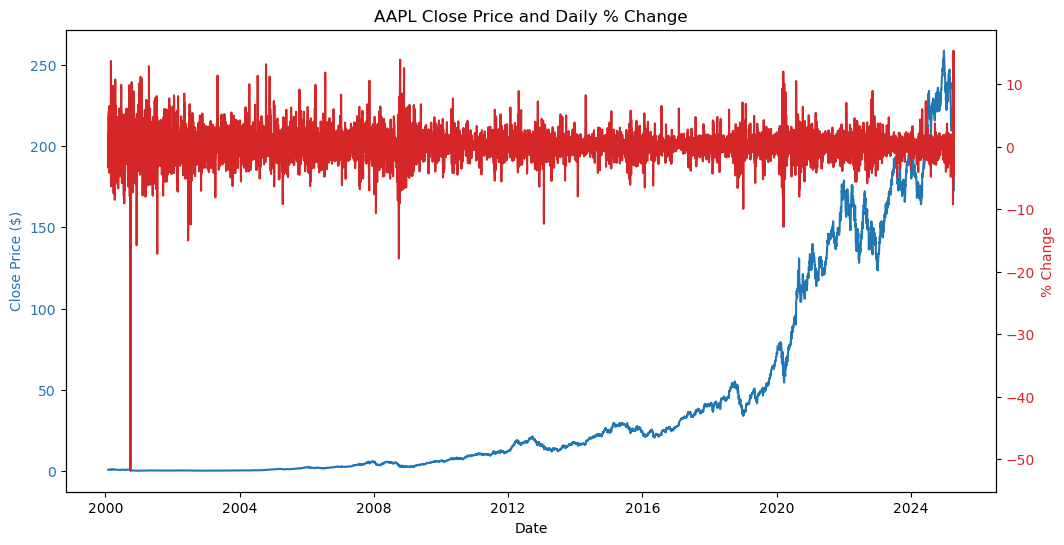

In [37]:
# ----------------------------
# Download Historical Data using yfinance
# ----------------------------
ticker_symbol = 'AAPL'
data = yf.download(ticker_symbol, start="2000-01-01", end="2025-04-11")
data.dropna(inplace=True)

# ----------------------------
# Calculate Technical Indicators (from previous example)
# ----------------------------
data['RSI'] = compute_RSI(data, window=14)

data['BB_Middle'], data['BB_Upper'], data['BB_Lower'] = compute_bollinger_bands(data, window=20, num_std=2)

window_ma = 20
data['SMA'] = data['Close'].rolling(window=window_ma).mean()
data['EMA'] = data['Close'].ewm(span=window_ma, adjust=False).mean()

ema_12 = data['Close'].ewm(span=12, adjust=False).mean()
ema_26 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = ema_12 - ema_26
data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

data['ATR'] = compute_ATR(data, window=14)

data['Sharpe_Ratio'] = compute_sharpe_ratio(data, window=14, risk_free_rate=0)

stock_info = yf.Ticker(ticker_symbol).info
pe_ratio = stock_info.get('trailingPE', np.nan)
data['PE_Ratio'] = pe_ratio

# ----------------------------
# Generate the Target Variable: % Change for the day
# ----------------------------

# Option 1: Same-Day % Change (In-Sample)
# Here we compute the percentage change of the closing price relative to the previous day's close.
data['Pct_Change'] = data['Close'].pct_change() * 100

# Option 2: Next-Day % Change (Forecasting)
# Uncomment the next line if you want your model to predict the next day's percentage change.
# data['Pct_Change'] = data['Close'].pct_change().shift(-1) * 100

# Drop rows with NaN values that can appear from the computations above (rolling indicators and percentage changes)
final_data = data.dropna().copy()

# Inspect the last few rows of the data to check the % change and features
print(final_data[['Close', 'Pct_Change', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'SMA', 'EMA', 'MACD', 'MACD_Signal', 'ATR', 'Sharpe_Ratio', 'PE_Ratio']].tail())

# Save the dataset with the target variable
final_data.to_csv("stock_data_with_features_and_target.csv")

# Example Plot: Close Price and % Change
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(final_data.index, final_data['Close'], label='Close Price', color='tab:blue')
ax1.set_xlabel("Date")
ax1.set_ylabel("Close Price ($)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(final_data.index, final_data['Pct_Change'], label='% Change', color='tab:red')
ax2.set_ylabel("% Change", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
plt.title(f"{ticker_symbol} Close Price and Daily % Change")
plt.show()


In [ ]:
# Instead of loading from CSV, let's use the data that was already prepared
# Using the variable 'final_data' from your previous code
# If you're running this in a new session, you'll need to rerun the data preparation code first

# Verify that 'final_data' exists and is properly formatted
print("Data shape:", final_data.shape)
print("Index type:", type(final_data.index))
print("First 5 rows of the index:", final_data.index[:5])


# New column names for the 17 columns currently present
new_columns = [
    'Close', 'High', 'Low', 'Open', 'Volume',
    'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower',
    'SMA', 'EMA', 'MACD', 'MACD_Signal',
    'ATR', 'Sharpe_Ratio', 'PE_Ratio', 'Pct_Change'
]
final_data.columns = new_columns

print("Columns in final_data:", final_data.columns.tolist())


# Make sure the index is datetime
if not isinstance(final_data.index, pd.DatetimeIndex):
    try:
        final_data.index = pd.to_datetime(final_data.index)
        print("Successfully converted index to datetime")
    except Exception as e:
        print(f"Error converting index to datetime: {e}")
        # If conversion fails, create a copy with a proper index
        final_data = final_data.reset_index()
        # Check if there's a date column
        date_cols = [col for col in final_data.columns if 'date' in col.lower()]
        if date_cols:
            final_data.set_index(date_cols[0], inplace=True)
            final_data.index = pd.to_datetime(final_data.index)
        else:
            print("No date column found, using numeric index")

# Assign to data variable for consistency with rest of the code
data = final_data.copy()
print(f"Data ranges from {data.index.min()} to {data.index.max()}")

# Split data into train (up to 2020), test (2020-2024) and future forecast (2024-2026)
train_data = data[data.index < '2020-01-01'].copy()
test_data = data[(data.index >= '2020-01-01') & (data.index < '2024-01-01')].copy()

# Check if we have data after 2024 (probably not as your original range was until 2023)
future_data = data[data.index >= '2024-01-01'].copy()

# Print the sizes of each dataset
print(f"Training data size: {len(train_data)} rows")
print(f"Testing data size: {len(test_data)} rows")
print(f"Future data size: {len(future_data)} rows")

# If we don't have future data in the dataset, we'll generate predictions for it later
if future_data.empty:
    print("Note: No future data available after 2024. Will generate forecasts using recursive approach.")

# Define features and target
features = ['RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'SMA', 'EMA',
           'MACD', 'MACD_Signal', 'ATR', 'Sharpe_Ratio', 'PE_Ratio']

# Add price data as features
price_features = ['Open', 'High', 'Low', 'Close', 'Volume']
features.extend(price_features)

# Remove any features that don't exist in the dataset
features = [f for f in features if f in data.columns]

target = 'Pct_Change'

# Verify target exists
if target not in data.columns:
    print(f"Warning: Target column '{target}' not found. Available columns: {data.columns.tolist()}")
    # Check if alternative exists
    if 'Pct_Change' in data.columns:
        target = 'Pct_Change'
        print(f"Using '{target}' as target instead")
    else:
        # Generate percent change if needed
        print("Generating percentage change from Close prices")
        data['Pct_Change'] = data['Close'].pct_change() * 100
        target = 'Pct_Change'

# Check for any missing values in features
'''for feature in features:
    if data[feature].isna().any():
        print(f"Warning: {feature} has {data[feature].isna().sum()} missing values")'''

# Drop any remaining NaN values
train_data = train_data.dropna(subset=features + [target])
test_data = test_data.dropna(subset=features + [target])

# Prepare the data
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Feature Selection - Recursive Feature Elimination with Cross-Validation
print("\nPerforming feature selection...")
# Use TimeSeriesSplit for cross-validation to respect time order
tscv = TimeSeriesSplit(n_splits=5)

# We'll use RFECV for feature selection
rfecv = RFECV(
    estimator=LinearRegression(),
    step=1,
    cv=tscv,
    scoring='neg_mean_squared_error',
    min_features_to_select=3,
    n_jobs=-1
)

rfecv.fit(X_train, y_train)

# Get the selected features
selected_features = [features[i] for i in range(len(features)) if rfecv.support_[i]]
print(f"Selected features: {selected_features}")

# Plot feature selection results
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.title('Feature Selection - Cross-validation Score vs Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Cross-validation Score (negative MSE)')
plt.savefig('feature_selection_results.png')
plt.close()

# Use selected features for training and testing
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Train XGBoost model
print("\nTraining XGBoost model...")
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train the model
model.fit(
    X_train_selected, y_train,
    eval_set=[(X_train_selected, y_train), (X_test_selected, y_test)],
    eval_metric='rmse',
    early_stopping_rounds=20,
    verbose=True
)

# Evaluate the model on the test set
y_pred = model.predict(X_test_selected)
test_data['Predicted_Pct_Change'] = y_pred

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest Set Performance:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R-squared: {r2:.4f}")

# Plot feature importance
plt.figure(figsize=(12, 6))
xgb.plot_importance(model, max_num_features=len(selected_features))
plt.title('Feature Importance')
plt.savefig('feature_importance.png')
plt.close()

# Plot actual vs predicted percentage change
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, test_data[target], label='Actual % Change', alpha=0.7)
plt.plot(test_data.index, test_data['Predicted_Pct_Change'], label='Predicted % Change', alpha=0.7)
plt.title('Actual vs Predicted % Change (Test Period)')
plt.xlabel('Date')
plt.ylabel('Percentage Change')
plt.legend()
plt.savefig('actual_vs_predicted.png')
plt.close()

# Calculate cumulative returns (how $1 would grow)
test_data['Actual_Cumulative_Return'] = (1 + test_data[target]/100).cumprod()
test_data['Predicted_Cumulative_Return'] = (1 + test_data['Predicted_Pct_Change']/100).cumprod()

# Plot cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, test_data['Actual_Cumulative_Return'], label='Actual Returns', alpha=0.7)
plt.plot(test_data.index, test_data['Predicted_Cumulative_Return'], label='Predicted Returns', alpha=0.7)
plt.title('Cumulative Returns (Test Period)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return ($)')
plt.legend()
plt.savefig('cumulative_returns.png')
plt.close()

# Implement recursive forecasting for future periods (2024-2026)
print("\nImplementing recursive forecasting for 2024-2026...")

# If we have ticker data, use it to get the most recent day's data
ticker_symbol = 'AAPL'  # Replace with your actual ticker if different
ticker = yf.Ticker(ticker_symbol)

# Get the last available date from our dataset
last_date = data.index.max()
print(f"Last date in dataset: {last_date}")

# Calculate the start date for forecasting (day after last date in dataset)
forecast_start = last_date + timedelta(days=1)
# Make sure it's a business day
while forecast_start.weekday() >= 5:  # 5 = Saturday, 6 = Sunday
    forecast_start += timedelta(days=1)

forecast_end = datetime(2026, 1, 1)
print(f"Forecasting from {forecast_start} to {forecast_end}")

# Get the last row of data to use as starting point
last_row = data.iloc[-1:].copy()

# Create an empty dataframe for our forecasts
forecast_dates = pd.date_range(start=forecast_start, end=forecast_end, freq='B')  # B = business days
forecast_data = pd.DataFrame(index=forecast_dates)

# Add predicted percentage change column
forecast_data['Predicted_Pct_Change'] = np.nan

# Add columns for features and initialize with NaN
for col in data.columns:
    forecast_data[col] = np.nan

# Recursive forecasting
current_date = forecast_start
forecast_horizon = len(forecast_dates)
print(f"Generating {forecast_horizon} days of forecasts...")

# For the first prediction, use the last row of the original data
current_data = last_row.copy()

# Transform the last_row to have the same features as our training data
X_current = current_data[selected_features]

for i, date in enumerate(forecast_dates):
    try:
        # Make prediction
        pred = model.predict(X_current[selected_features])[0]

        # Store the predicted percentage change
        forecast_data.loc[date, 'Predicted_Pct_Change'] = pred

        # Create next row based on current data
        next_row = current_data.copy()

        # Update Close price based on predicted percentage change
        current_close = current_data['Close'].values[0]
        next_close = current_close * (1 + pred/100)

        # Simple assumption for other price columns (can be refined)
        price_change = next_close - current_close
        next_row['Close'] = next_close
        next_row['Open'] = next_close - (price_change * 0.2)  # Simplified
        next_row['High'] = next_close + (price_change * 0.1)  # Simplified
        next_row['Low'] = next_close - (price_change * 0.1)   # Simplified

        # Simplified volume calculation (using average of last 30 days if available)
        if len(data) >= 30:
            avg_volume = data['Volume'].tail(30).mean()
            next_row['Volume'] = avg_volume

        # Update the forecast dataframe with the values
        for col in next_row.columns:
            forecast_data.loc[date, col] = next_row[col].values[0]

        # For the next prediction, we need to create a new current_data with updated features
        # This would ideally recalculate all technical indicators based on the updated price history
        # For simplicity, we'll just update the current_data with the next_row values
        current_data = next_row.copy()

        # Print progress
        if i % 63 == 0:  # About quarterly
            print(f"Generated {i+1}/{forecast_horizon} forecasts. Current date: {date.strftime('%Y-%m-%d')}")
    except Exception as e:
        print(f"Error at date {date}: {e}")
        # Continue with the next date
        continue

# Save the forecast to CSV
forecast_data.to_csv('stock_forecast_2024_2026.csv')

# Plot the forecasted percentage change
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, test_data[target], label='Historical % Change', alpha=0.7)
plt.plot(test_data.index, test_data['Predicted_Pct_Change'], label='Predicted % Change (Test)', alpha=0.7)
plt.plot(forecast_data.index, forecast_data['Predicted_Pct_Change'], label='Forecasted % Change (2024-2026)', alpha=0.7)
plt.title('Historical, Predicted, and Forecasted % Change')
plt.xlabel('Date')
plt.ylabel('Percentage Change')
plt.legend()
plt.savefig('forecast_pct_change.png')
plt.close()

# Calculate cumulative returns for the forecast period
forecast_data['Forecast_Cumulative_Return'] = (1 + forecast_data['Predicted_Pct_Change']/100).cumprod()

# Create combined plot of historical and forecasted cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, test_data['Actual_Cumulative_Return'], label='Actual Returns (Test)', alpha=0.7)
plt.plot(test_data.index, test_data['Predicted_Cumulative_Return'], label='Predicted Returns (Test)', alpha=0.7)
plt.plot(forecast_data.index, forecast_data['Forecast_Cumulative_Return'], label='Forecasted Returns (2024-2026)', alpha=0.7)
plt.title('Historical and Forecasted Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return ($)')
plt.legend()
plt.savefig('forecast_cumulative_returns.png')
plt.close()

print("\nForecasting complete. Results saved to CSV and plots generated.")

# Bonus: Create a trading strategy based on the forecasts
print("\nGenerating a simple trading strategy...")

# Simple strategy: Buy when predicted % change is positive, sell when negative
test_data['Position'] = np.where(test_data['Predicted_Pct_Change'] > 0, 1, -1)  # 1 = long, -1 = short
test_data['Strategy_Return'] = test_data['Position'].shift(1) * test_data[target]  # Shift by 1 to avoid look-ahead bias
test_data['Strategy_Cumulative_Return'] = (1 + test_data['Strategy_Return']/100).cumprod()

# Apply the same strategy to forecast data
forecast_data['Position'] = np.where(forecast_data['Predicted_Pct_Change'] > 0, 1, -1)
# For the forecast, we're using the predicted percentage change as we don't have actual returns
forecast_data['Strategy_Return'] = forecast_data['Position'] * forecast_data['Predicted_Pct_Change']
forecast_data['Strategy_Cumulative_Return'] = (1 + forecast_data['Strategy_Return']/100).cumprod()

# Plot the strategy returns
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, test_data['Actual_Cumulative_Return'], label='Buy & Hold', alpha=0.7)
plt.plot(test_data.index, test_data['Strategy_Cumulative_Return'], label='Strategy (Test)', alpha=0.7)
plt.plot(forecast_data.index, forecast_data['Strategy_Cumulative_Return'], label='Strategy (Forecast)', alpha=0.7)
plt.title('Trading Strategy Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Return ($)')
plt.legend()
plt.savefig('trading_strategy.png')
plt.close()

# Calculate strategy performance metrics
strategy_return = test_data['Strategy_Return'].mean()
strategy_std = test_data['Strategy_Return'].std()
sharpe_ratio = (strategy_return - 0) / strategy_std * np.sqrt(252)  # Annualized Sharpe Ratio

buy_hold_return = test_data[target].mean()
buy_hold_std = test_data[target].std()
buy_hold_sharpe = (buy_hold_return - 0) / buy_hold_std * np.sqrt(252)

final_strategy_return = test_data['Strategy_Cumulative_Return'].iloc[-1]
final_buy_hold_return = test_data['Actual_Cumulative_Return'].iloc[-1]

print("\nStrategy Performance (Test Period):")
print(f"Average Daily Return: {strategy_return:.4f}%")
print(f"Daily Standard Deviation: {strategy_std:.4f}%")
print(f"Annualized Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Total Return: {(final_strategy_return - 1) * 100:.2f}%")

print("\nBuy & Hold Performance (Test Period):")
print(f"Average Daily Return: {buy_hold_return:.4f}%")
print(f"Daily Standard Deviation: {buy_hold_std:.4f}%")
print(f"Annualized Sharpe Ratio: {buy_hold_sharpe:.4f}")
print(f"Total Return: {(final_buy_hold_return - 1) * 100:.2f}%")

print("\nAnalysis complete. All plots and data files have been saved.")

Data shape: (6338, 17)
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
First 5 rows of the index: DatetimeIndex(['2000-01-31', '2000-02-01', '2000-02-02', '2000-02-03',
               '2000-02-04'],
              dtype='datetime64[ns]', name='Date', freq=None)
Columns in final_data: ['Close', 'High', 'Low', 'Open', 'Volume', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'SMA', 'EMA', 'MACD', 'MACD_Signal', 'ATR', 'Sharpe_Ratio', 'PE_Ratio', 'Pct_Change']
Data ranges from 2000-01-31 00:00:00 to 2025-04-10 00:00:00
Training data size: 5012 rows
Testing data size: 1006 rows
Future data size: 320 rows
Training data shape: (5012, 16)
Testing data shape: (1006, 16)

Performing feature selection...
